# Singular Value Decomposition and Eigenfaces

In [ ]:
import cv2
import zipfile
import numpy as np
import matplotlib.pyplot as plt
faces = {}
# load the images dataset
with zipfile.ZipFile("attface.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue # not a face picture
        with facezip.open(filename) as image:
            # opencv load the filename files
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)

faceimages = np.asarray(list(faces.values())[0:400:2])
faceimages_test = np.asarray(list(faces.values())[1:401:2])
print(faceimages.shape)
# 3d stands for (index,height,width)
# To make it clear:
# faceimages is a 3d array where the first index is to index the images
# Second and third are to index the image height and width directions.

def plot_single_face(img):
  img_arr = np.reshape(img, (112, 92))
  plt.figure()
  plt.imshow(img_arr, cmap='gray')
  plt.show()



(200, 112, 92)


## Constructing the face-image matrix


[[48]
 [49]
 [45]
 ...
 [47]
 [46]
 [46]]


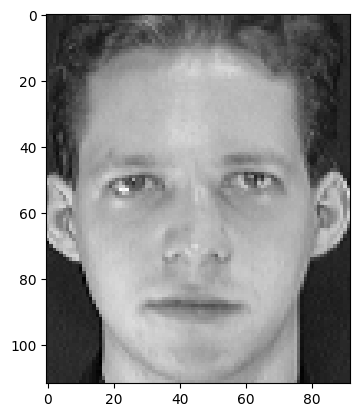

In [ ]:
row_vect = faceimages[[0],:,:] # Take out the 0th face image
col_vect = row_vect.reshape((10304,1))
print(col_vect)
plot_single_face(col_vect)

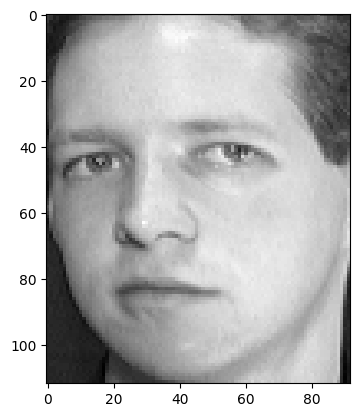

In [ ]:
# The shape of faceimages are (200, 112, 92)
# where faceimage[i, :, :] is the i-th face image.
# Generate the matrix A whose size is (10304, 200) according to face image
# The column vectors of matrix A will stands for the face images.

A = faceimages.reshape(200,112*92).T
# print the shape of the matrix A you generated


plot_single_face(A[:, 2]) # Make sure the plot is a human face

## PCA on the face-image matrix

In [ ]:
def plot_eigenface(B_hat):
  k = B_hat.shape[1]
  fig, axes = plt.subplots(5,4,sharex=True,sharey=True,figsize=(8,10))
  for i in range(k):
    img_tmp = np.reshape(B_hat[:, i], (112, 92))
    axes[i//4][i%4].imshow(img_tmp, cmap="gray")
  plt.show()

In [ ]:
# Step(a) center the face-image matrix A
##############################################################################
a,b = A.shape
ones = np.ones((b,1))
A_bar = A - 1/b * A@ones@ones.T # centered A
print(A_bar)

#############################################################################

[[-36.97  -24.97  -21.97  ...  29.03   28.03   26.03 ]
 [-35.79  -24.79  -31.79  ...  25.21   27.21   29.21 ]
 [-40.055 -23.055 -50.055 ...  26.945  25.945  26.945]
 ...
 [-29.39  -44.39  -35.39  ...  16.61   10.61   11.61 ]
 [-27.815 -39.815 -63.815 ...  15.185  13.185  12.185]
 [-26.215 -38.215 -48.215 ...  13.785  16.785  19.785]]


In [ ]:
# Step(b) Perform SVD on A_bar
#############################################################################

U, sigma, V_T = np.linalg.svd(A_bar)
print(U.shape, sigma.shape, V_T.shape)
#############################################################################

(10304, 10304) (200,) (200, 200)


In [ ]:
# Step (c) Using the top k=20 principal components to contruct B_hat and W_hat
#############################################################################

B_hat = U[:,:20]

W_hat = np.diag(sigma[:20])@V_T[:20,:]
print(B_hat.shape, W_hat.shape) # checking the dimensions
#############################################################################

(10304, 20) (20, 200)


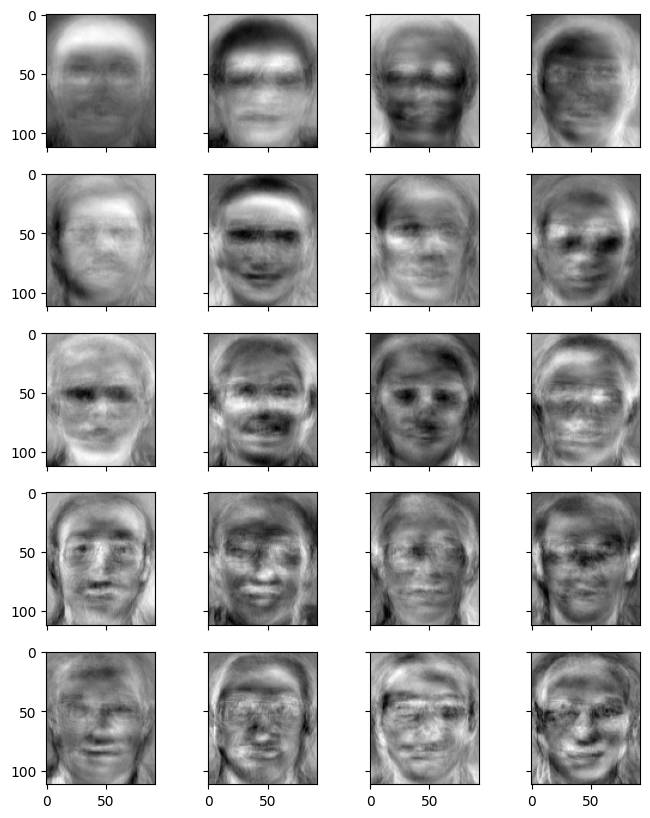

In [ ]:
# Step (d) Plot the B_hat components
plot_eigenface(B_hat)

## Face recognition based on eigenfaces

In [ ]:
def visualize_recognition(ind, test_img, faceimages):
  plt.figure()
  plt.subplot(1, 2, 1)
  plt.imshow(np.squeeze(test_img, axis=0), cmap="gray") # Updated here
  plt.subplot(1, 2, 2)
  best_match = faceimages[ind, :, :]
  plt.imshow(best_match, cmap="gray")
  plt.show()

In [ ]:
# 3 test images
test_img1 = faceimages_test[[15], :, :]
test_img2 = faceimages_test[[25], :, :]
test_img3 = faceimages_test[[55], :, :]

In [ ]:
# Step(a) Vectorize 3 test images
#############################################################################
z_1 = test_img1.reshape((1,-1)).T  #vectorize test_img1
z_2 = test_img2.reshape((1,-1)).T   #vectorize test_img2
z_3 = test_img3.reshape((1,-1)).T   #vectorize test_img3
#############################################################################

In [ ]:
# Step (b) Center each of the 3 vectors according to equation (10)
#############################################################################
z_1_bar = z_1 - 1/b*A@ones  # center z_1
z_2_bar = z_2 - 1/b*A@ones  # center z_2
z_3_bar = z_3 - 1/b*A@ones  # center z_3
#############################################################################

In [ ]:
# Step (c) Compute the representations of the 3 vectors with respect to the B_hat
# according to equation (11)
#############################################################################
w_1 = B_hat.T@z_1_bar  # caculate according to z_1_bar and B_hat
w_2 = B_hat.T@z_2_bar  # caculate according to z_2_bar and B_hat
w_3 = B_hat.T@z_3_bar  # caculate according to z_3_bar and B_hat
#############################################################################

In [ ]:
# Step (d) for each corresponding vector for the 3 test images,
# find its nearest neighbor in the training set: faceimages .
#############################################################################
distance = np.zeros(b)
for i in range(b):
  distance[i] = np.linalg.norm(w_1 - W_hat[:,[i]])
ind_1 = np.argmin(distance)
distance = np.zeros(b)
for i in range(b):
  distance[i] = np.linalg.norm(w_2 - W_hat[:,[i]])
ind_2 = np.argmin(distance)
distance = np.zeros(b)
for i in range(b):
  distance[i] = np.linalg.norm(w_3 - W_hat[:,[i]])
ind_3 = np.argmin(distance)
#############################################################################

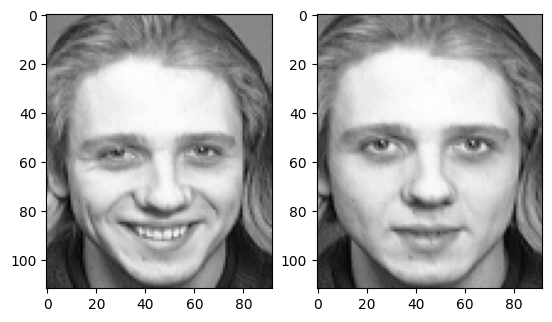

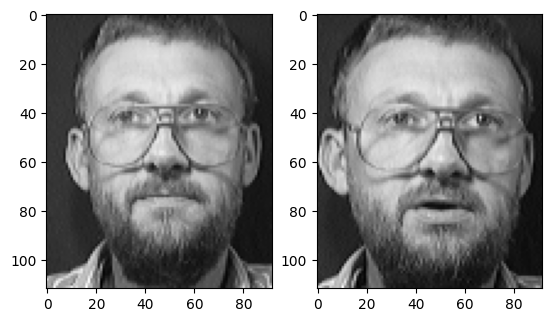

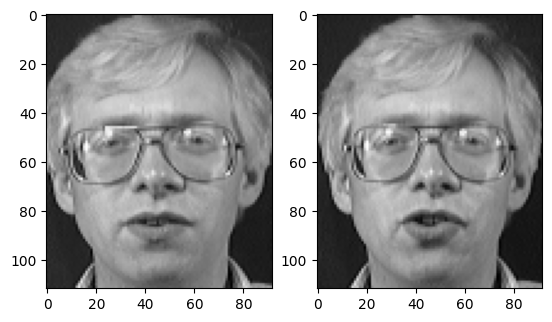

In [ ]:
visualize_recognition(ind_1, test_img1, faceimages)
visualize_recognition(ind_2, test_img2, faceimages)
visualize_recognition(ind_3, test_img3, faceimages)

# Image compression using the SVD

In [ ]:
# function that plots an image that is in a 2D array format
def visualize_rec_img(img):
  plt.figure()
  plt.imshow(img, cmap='gray')
  plt.show()

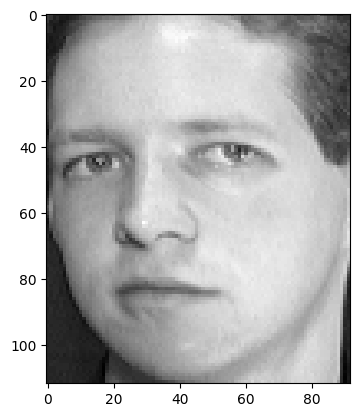

In [ ]:
# image we want to compress
img = np.reshape(A[:,2], (112,92))
visualize_rec_img(img)

##Compressing the images and visualizing them

In [ ]:
# the number of singular values and vectors we want to look at
# to compare the different image compressions
num_singular_values = [1,5,10,15,20,40,92]
compressed_imgs = []
entries_stored = []

# compare the outputs of the different compressions
for k in num_singular_values:
  compressed_img = np.zeros(img.shape)
#############################################################################
  U_img, sig_img, V_T_img = np.linalg.svd(img)
  U_comp = U_img[:,:k]
  V_T_comp = V_T_img[:k,:]
  sig_comp = sig_img[:k]
  compressed_img = U_comp @ np.diag(sig_comp)@V_T_comp
  compressed_imgs.append(compressed_img)
  entries_stored.append(U_comp.shape[0]*U_comp.shape[1]+V_T_comp.shape[0]*V_T_comp.shape[1]+sig_comp.shape[0])

###################################################################




Compression using largest 1 singular values:



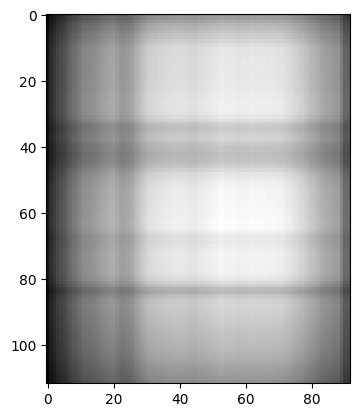




Compression using largest 5 singular values:



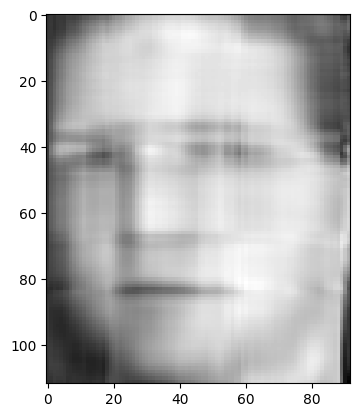




Compression using largest 10 singular values:



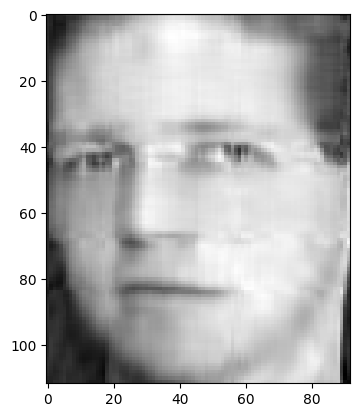




Compression using largest 15 singular values:



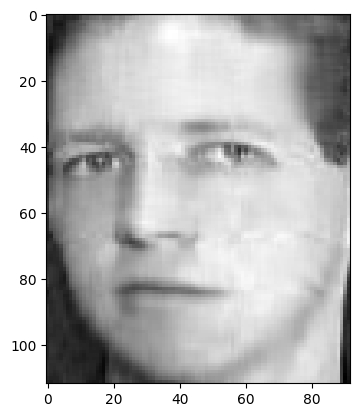




Compression using largest 20 singular values:



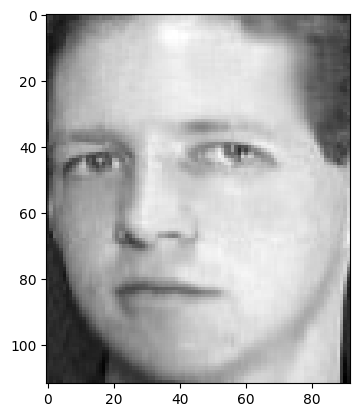




Compression using largest 40 singular values:



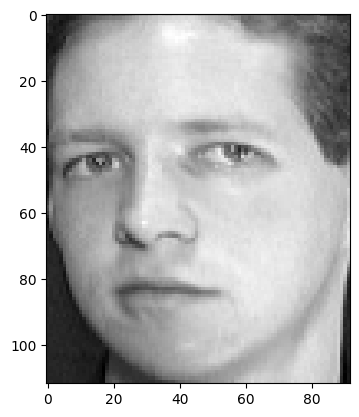




Compression using largest 92 singular values:



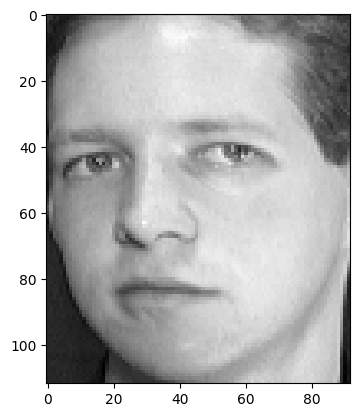

In [ ]:
for i in range(len(compressed_imgs)):
  print(f"\n\n\nCompression using largest {num_singular_values[i]} singular values:\n")
  visualize_rec_img(compressed_imgs[i])


### What do you observe about the way the image looks with respect to the how many of the largest singular values and their respective singular vectors we use to reconstruct it? What information seems to be carried by the largest singular values and their respective singular vectors and what seems to be carried by the smallest singular values and their respective vectors?

**Answer**

When reconstructing an image using SVD, the largest singular values capture essential features like shape and structure, preserving the core visual content and general contrasts. In contrast, the smallest singular values hold finer details and textures, but also encode noise, which can degrade image quality if overly included.

### Comparing storage for different the compressed images with respect to how many of the largest singular values and their respective singular vectors are used to reconstruct the image.

In [ ]:
for i in range(len(num_singular_values)):
  print(f"Entries stored for compression using {num_singular_values[i]} largest singular values: {entries_stored[i]}")

Entries stored for compression using 1 largest singular values: 205
Entries stored for compression using 5 largest singular values: 1025
Entries stored for compression using 10 largest singular values: 2050
Entries stored for compression using 15 largest singular values: 3075
Entries stored for compression using 20 largest singular values: 4100
Entries stored for compression using 40 largest singular values: 8200
Entries stored for compression using 92 largest singular values: 18860


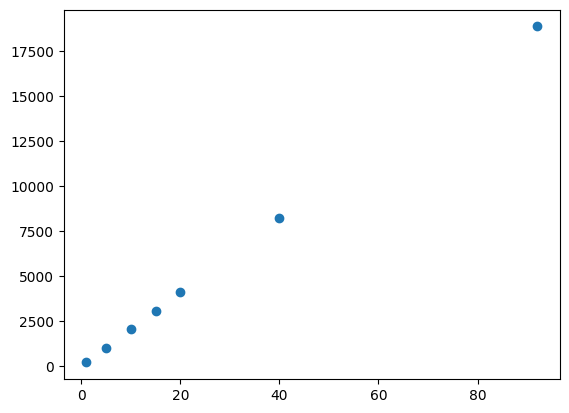

In [ ]:
# plot number of singular values vs storage
plt.figure()
plt.scatter(num_singular_values, entries_stored)
plt.show()


### What kind of relationship do you think exist between the number of entries stored and the number of singular values used to reconstruct the image?



**Answer**

The relationship between the number of entries stored and the number of singular values used is direct; more singular values increase the detail and fidelity of the reconstructed image, capturing finer textures and nuances, while fewer singular values simplify the image, retaining only major shapes and structures.

### Choosing the compressed image

Original image: 


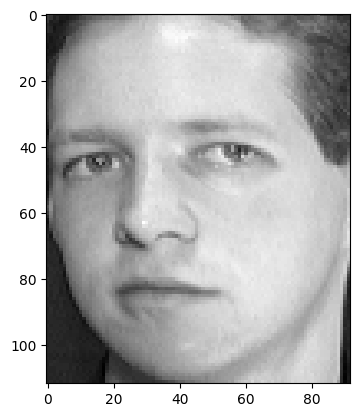



Chosen compressed image:


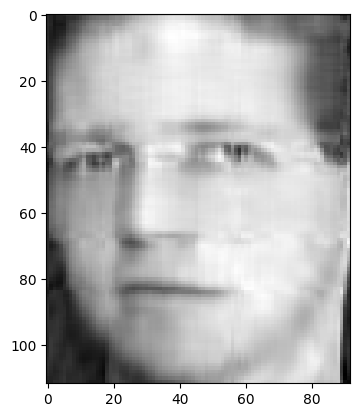



Storage space used relative to the original image 20%


In [ ]:
chosen_k = 92
#############################################
# pick a value of k from the list [1,5,10,15,20,40,92]
# that seems to give a good reconstruction
# of the image but saves you a significant amount of space in storage

chosen_k = 10

#############################################

index = num_singular_values.index(chosen_k)
print("Original image: ")
visualize_rec_img(img)
print("\n\nChosen compressed image:")
visualize_rec_img(compressed_imgs[index])
print(f"\n\nStorage space used relative to the original image {100*(entries_stored[index]/(112*92)):.0f}%")